## Import libraries

In [1]:
!python -V

Python 3.6.10


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
#from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
#from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
#from sklearn.datasets import make_classification
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from numpy import interp
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pickle
#import keras
from sklearn import preprocessing
import sklearn as sk
print('SKlearn version:',sk.__version__)
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)

SKlearn version: 0.22.2.post1
Numpy version: 1.18.1
Pandas version: 1.0.3


In [3]:
import shap
import matplotlib.pylab as pl
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import learning_curve, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, balanced_accuracy_score, precision_recall_curve, auc, average_precision_score

In [4]:
%matplotlib inline
#plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib as mpl
import sklearn
from sklearn.metrics import confusion_matrix
from tensorboard.plugins.hparams import api as hp
from tensorflow import feature_column
from tensorflow.keras import layers

In [6]:
from sklearn.model_selection import StratifiedKFold
import numpy

In [7]:
seed = 7
numpy.random.seed(seed)

In [8]:
seed

7

## Import dataset

In [9]:
df=pd.read_csv('dengue data-Final.csv')
df=df.drop(['RNA'],  axis=1)

In [10]:
train_df, test_df = train_test_split(df, test_size=.1, 
                                         stratify=df.Severity, random_state=seed)

In [11]:
train_df.head()

,Severity,sex,age,NS1,IgM,IgG
123,0,1,20,1,1,0
696,0,0,46,1,0,1
153,0,0,36,0,1,0
157,0,1,49,1,0,0
560,1,1,69,1,0,0


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 123 to 21
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Severity  718 non-null    int64
 1   sex       718 non-null    int64
 2   age       718 non-null    int64
 3   NS1       718 non-null    int64
 4   IgM       718 non-null    int64
 5   IgG       718 non-null    int64
dtypes: int64(6)
memory usage: 39.3 KB


## Data preprocessing piprlines
Prepare the data to a format that can be fit into scikit learn algorithms

**Transform data in a pipeline** 

In [13]:
def PreprocessData (raw_df):
    ndarray=raw_df.values
    Label=ndarray[:,0]
    Features=raw_df.drop(['Severity'], axis=1)
    Features['age']=Features['age']/100
    scaleFeatures=Features.values
        
    return scaleFeatures, Label

In [14]:
train_Features, train_Label=PreprocessData(train_df)
test_Features, test_Label=PreprocessData(test_df)

In [15]:
X, Y=PreprocessData(df)

In [16]:
train_Features.shape

(718, 5)

In [17]:
test_Features.shape

(80, 5)

## Fitting classifiers

In [18]:
train_df['Severity'].value_counts()

0    594
1    124
Name: Severity, dtype: int64

This is an unbalanced dataset(i.e., the number of positive and negative cases are not the same), and we'll use AUCROC as our metric to optimise the model performance.

In [19]:
def plot_learning_curves(model, X, y):

    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='roc_auc',
                                                           random_state=42, n_jobs=-1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", label="training scores")
    plt.plot(train_sizes, np.mean(val_scores, axis=1), "o-", label="x-val scores")
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.xlabel("Training set size")
    plt.ylabel("Average_precision")
    plt.title('{} learning curve'.format(model.__class__.__name__))

In [20]:
def plot_roc_curve(fpr, tpr, auc, model=None):
    if model == None:
        title = None
    elif isinstance(model, str):
        title = model
    else:
        title = model.__class__.__name__
#    title = None if model == None else model.__class__.__name__
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, linewidth=2, label='auc: {}'.format(auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-.01, 1.01, -.01, 1.01])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.title('{} - ROC Curve'.format(title))

In [21]:
def plot_precision_recall_curve(fpr, tpr, auprc, model=None):
    if model == None:
        title = None
    elif isinstance(model, str):
        title = model
    else:
        title = model.__class__.__name__
#    title = None if model == None else model.__class__.__name__
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, linewidth=2, label='AUPRC: {}'.format(auprc))
    plt.plot([0, 1], [0.1, 0.1], 'k--')
    plt.axis([-.01, 1.01, -.01, 1.01])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.title('{} - PR Curve'.format(title))

### _Logistic Regression model_

In [22]:
# Import model and retrain
with open('./finalmodel/lr_clf_final_round.pkl', 'rb') as f:
    lr_clf = pickle.load(f)
lr_clf.fit(train_Features, train_Label)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy scores

In [23]:
accu_lr = accuracy_score(test_Label, lr_clf.predict(test_Features))
accu_lr

0.875

Balance accuracy score

In [24]:
balance_accu_lr=balanced_accuracy_score(test_Label, lr_clf.predict(test_Features))
balance_accu_lr

0.6428571428571428

In [25]:
pd.crosstab(test_Label, lr_clf.predict(test_Features))

col_0,0,1
row_0,,
0,66,0
1,10,4


ROC and AUC

In [26]:
pred_proba_lr = lr_clf.predict_proba(test_Features)
fpr_lr, tpr_lr, _ = roc_curve(test_Label, pred_proba_lr[:, 1])
auc_lr = roc_auc_score(test_Label, pred_proba_lr[:, 1])

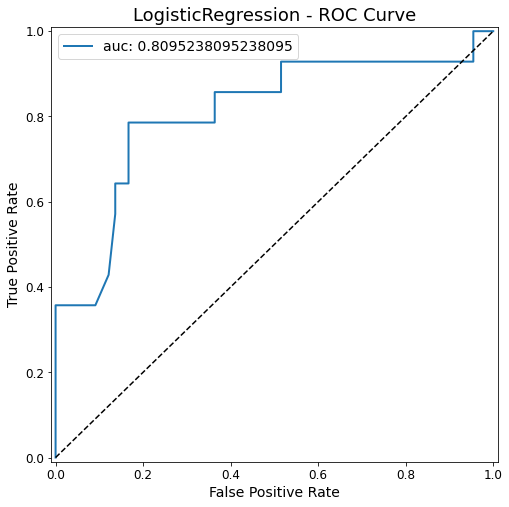

In [27]:
plot_roc_curve(fpr_lr, tpr_lr, auc_lr, lr_clf)

auc_lr_prc=0.6104 ap_lr=0.6187


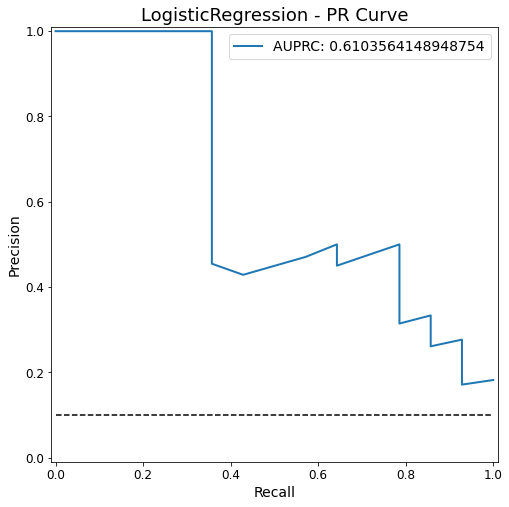

In [28]:
pred_proba_lr = pred_proba_lr[:, 1]
# predict class values
yhat = lr_clf.predict(test_Features)
# calculate precision-recall curve
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(test_Label, pred_proba_lr)
# calculate precision-recall AUC
auc_lr_pr=auc(recall_lr, precision_lr)
# calculate average precision score
ap_lr_pr = average_precision_score(test_Label, pred_proba_lr)
print('auc_lr_prc=%.4f ap_lr=%.4f' % (auc_lr_pr, ap_lr_pr))

plot_precision_recall_curve(recall_lr, precision_lr, auc_lr_pr, lr_clf)

### _Random forests model_

In [29]:
# Import model and retrain
with open('./finalmodel/rf_clf_final_round.pkl', 'rb') as f:
    rf_clf = pickle.load(f)
rf_clf.fit(train_Features, train_Label)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=94, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=13, min_samples_split=13,
                       min_weight_fraction_leaf=0.0, n_estimators=23,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

Accuracy scores

In [30]:
accu_rf = accuracy_score(test_Label, rf_clf.predict(test_Features))
accu_rf

0.825

Balance accuracy scores

In [31]:
balance_accu_rf=balanced_accuracy_score(test_Label, rf_clf.predict(test_Features))
balance_accu_rf

0.5281385281385281

In [32]:
pd.crosstab(test_Label, rf_clf.predict(test_Features))

col_0,0,1
row_0,,
0,65,1
1,13,1


ROC and AUC

In [33]:
pred_proba_rf = rf_clf.predict_proba(test_Features)
fpr_rf, tpr_rf, _ = roc_curve(test_Label, pred_proba_rf[:, 1])
auc_rf = roc_auc_score(test_Label, pred_proba_rf[:, 1])

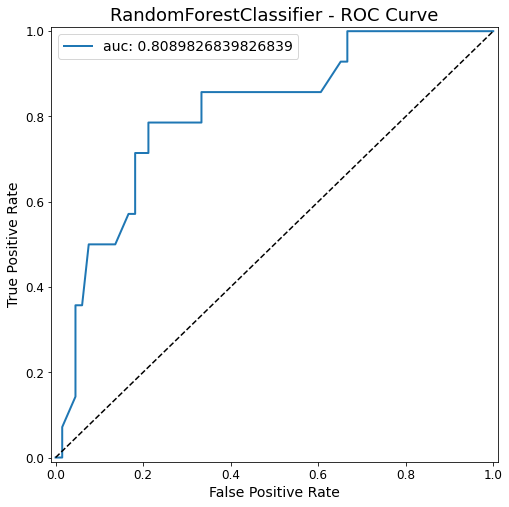

In [34]:
plot_roc_curve(fpr_rf, tpr_rf, auc_rf, rf_clf)

auc_rf=0.4246 ap_rf=0.4543


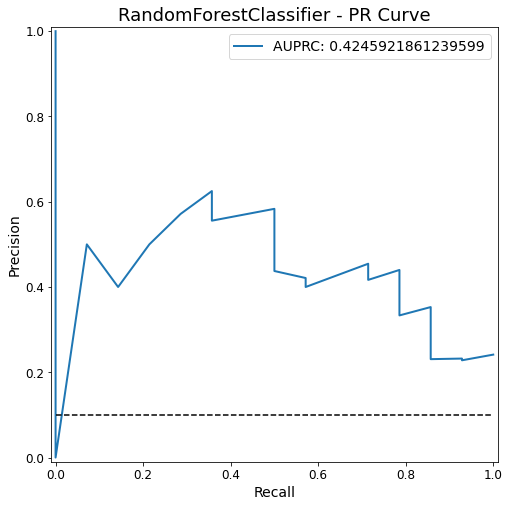

In [35]:
pred_proba_rf = pred_proba_rf[:, 1]
# predict class values
yhat = rf_clf.predict(test_Features)
# calculate precision-recall curve
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(test_Label, pred_proba_rf)
# calculate precision-recall AUC
auc_rf_pr=auc(recall_rf, precision_rf)
# calculate average precision score
ap_rf_pr = average_precision_score(test_Label, pred_proba_rf)
print('auc_rf=%.4f ap_rf=%.4f' % (auc_rf_pr, ap_rf_pr))

plot_precision_recall_curve(recall_rf, precision_rf, auc_rf_pr, rf_clf)

### _Gradient boosting machine model_

In [36]:
# Import model and retrain
with open('finalmodel/gbm_clf_final_round.pkl', 'rb') as f:
    gbm_clf = pickle.load(f)
gbm_clf.fit(train_Features, train_Label)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=12,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=63, min_samples_split=15,
                           min_weight_fraction_leaf=0.0, n_estimators=174,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=7, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Accuracy scores

In [37]:
accu_gbm = accuracy_score(test_Label, gbm_clf.predict(test_Features))
accu_gbm

0.8375

Balance accuracy scores

In [38]:
balance_accu_gbm=balanced_accuracy_score(test_Label, gbm_clf.predict(test_Features))
balance_accu_gbm

0.6201298701298701

In [39]:
pd.crosstab(test_Label, gbm_clf.predict(test_Features))

col_0,0,1
row_0,,
0,63,3
1,10,4


ROC and AUC

In [40]:
pred_proba_gbm = gbm_clf.predict_proba(test_Features)
fpr_gbm, tpr_gbm, _ = roc_curve(test_Label, pred_proba_gbm[:, 1])
auc_gbm = roc_auc_score(test_Label, pred_proba_gbm[:, 1])

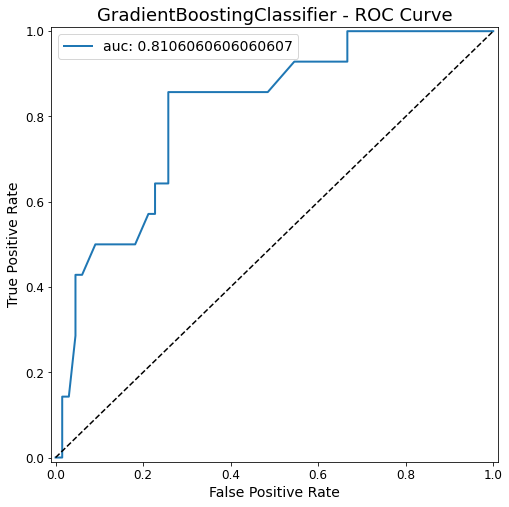

In [41]:
plot_roc_curve(fpr_gbm, tpr_gbm, auc_gbm, gbm_clf)

auc_gbm=0.4347 ap_gbm=0.4733


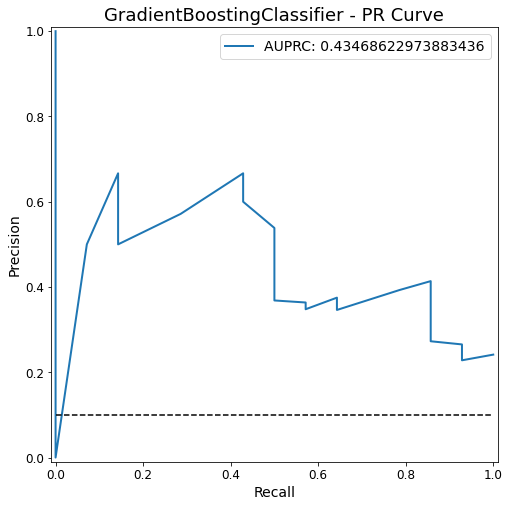

In [42]:
# keep probabilities for the positive outcome only
pred_proba_gbm = pred_proba_gbm[:, 1]
# predict class values
yhat = gbm_clf.predict(test_Features)
# calculate precision-recall curve
precision_gbm, recall_gbm, thresholds_gbm = precision_recall_curve(test_Label, pred_proba_gbm)

# calculate precision-recall AUC
auc_gbm_pr=auc(recall_gbm, precision_gbm)
# calculate average precision score
ap_gbm_pr = average_precision_score(test_Label, pred_proba_gbm)
print('auc_gbm=%.4f ap_gbm=%.4f' % (auc_gbm_pr, ap_gbm_pr))

plot_precision_recall_curve(recall_gbm, precision_gbm, auc_gbm_pr, gbm_clf)

### _Support vector machine model_

In [43]:
# Import model and retrain
with open('./finalmodel/svc_clf_final_round.pkl', 'rb') as f:
    svc_clf = pickle.load(f)
svc_clf.fit(train_Features, train_Label)

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=7, shrinking=True, tol=0.001,
    verbose=False)

Accuracy scores

In [44]:
accu_svc = accuracy_score(test_Label, svc_clf.predict(test_Features))
accu_svc

0.7

Balance accuracy scores

In [45]:
balance_accu_svc=balanced_accuracy_score(test_Label, svc_clf.predict(test_Features))
balance_accu_svc

0.7619047619047619

In [46]:
pd.crosstab(test_Label, svc_clf.predict(test_Features))

col_0,0,1
row_0,,
0,44,22
1,2,12


ROC and AUC

In [47]:
pred_proba_svc = svc_clf.predict_proba(test_Features)
fpr_svc, tpr_svc, _ = roc_curve(test_Label, pred_proba_svc[:, 1])
auc_svc = roc_auc_score(test_Label, pred_proba_svc[:, 1])

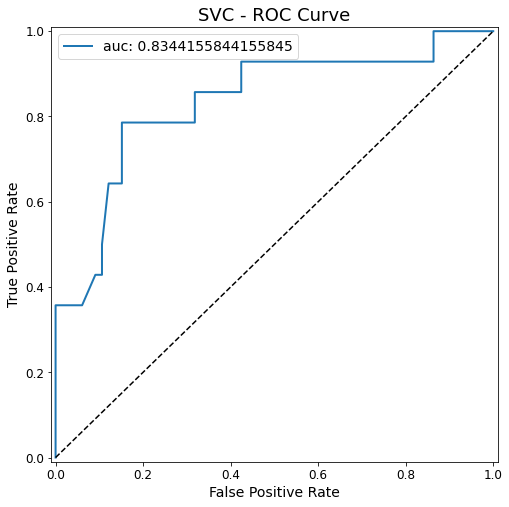

In [48]:
plot_roc_curve(fpr_svc, tpr_svc, auc_svc, svc_clf)

auc_svc=0.6349 ap_svc=0.6417


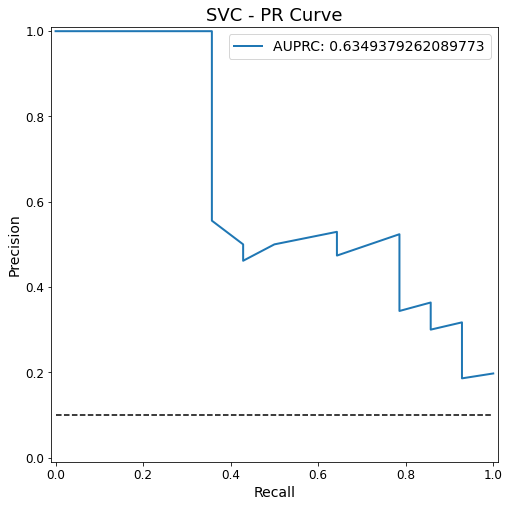

In [49]:
# keep probabilities for the positive outcome only
pred_proba_svc = pred_proba_svc[:, 1]
# predict class values
yhat = svc_clf.predict(test_Features)
# calculate precision-recall curve
precision_svc, recall_svc, thresholds = precision_recall_curve(test_Label, pred_proba_svc)
# calculate precision-recall AUC
auc_svc_pr=auc(recall_svc, precision_svc)
# calculate average precision score
ap_svc_pr = average_precision_score(test_Label, pred_proba_svc)
print('auc_svc=%.4f ap_svc=%.4f' % (auc_svc_pr, ap_svc_pr))

plot_precision_recall_curve(recall_svc, precision_svc, auc_svc_pr, svc_clf)

# Deep Learning

# NL model evaluation

In [50]:
model=tf.keras.models.load_model('./finalmodel/ANN_test_model.h5')

In [51]:
model.summary()

Model: "sequential_2560"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10240 (Dense)          (None, 100)               600       
_________________________________________________________________
dropout_5120 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_10241 (Dense)          (None, 150)               15150     
_________________________________________________________________
dropout_5121 (Dropout)       (None, 150)               0         
_________________________________________________________________
dense_10242 (Dense)          (None, 150)               22650     
_________________________________________________________________
dense_10243 (Dense)          (None, 1)                 151       
Total params: 38,551
Trainable params: 38,551
Non-trainable params: 0
_______________________________________________

In [52]:
unique, counts = np.unique(train_Label, return_counts=True)
weight_for_0 = (1 / counts[0])*(counts.sum())/2.0 
weight_for_1 = (1 / counts[1])*(counts.sum())/2.0
class_weights = {0: weight_for_0, 1: weight_for_1}

model.fit(train_Features, train_Label, class_weight=class_weights,
          epochs=400, batch_size=20, verbose=0) 

col_0,0,1
Severity,,
0,45,21
1,2,12


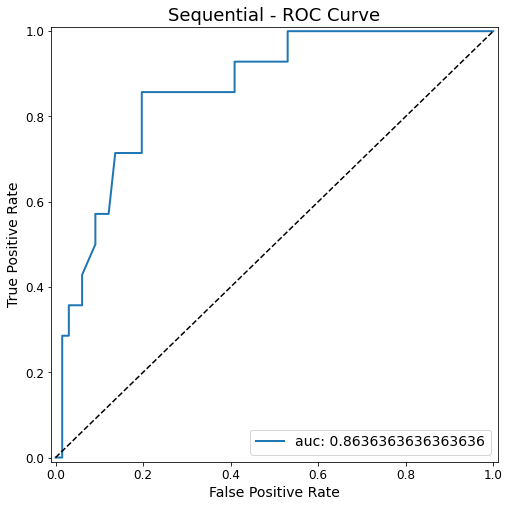

In [53]:
test_probability=model.predict(test_Features)

from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr_NL, tpr_NL, _ = roc_curve(test_Label, test_probability)
auc_NL = roc_auc_score(test_Label, test_probability)
plot_roc_curve(fpr_NL, tpr_NL, auc_NL, model)

test_class=model.predict_classes(test_Features)

pd.crosstab(test_df['Severity'], test_class[:,0])

auc_NL_pr=0.5175 ap=0.5546


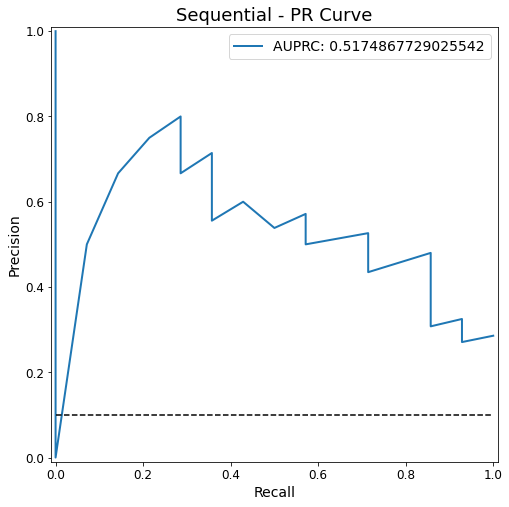

In [54]:
# predict probabilities

pred_proba_NL = np.reshape(test_probability, test_probability.shape[0])
# keep probabilities for the positive outcome only

# predict class values
yhat = test_class
# calculate precision-recall curve
precision_NL, recall_NL, thresholds = precision_recall_curve(test_Label, pred_proba_NL)
# calculate precision-recall AUC
auc_NL_pr=auc(recall_NL, precision_NL)
# calculate average precision score
ap_NL_pr = average_precision_score(test_Label, pred_proba_NL)
print('auc_NL_pr=%.4f ap=%.4f' % (auc_NL_pr, ap_NL_pr))

plot_precision_recall_curve(recall_NL, precision_NL, auc_NL_pr, model)

In [55]:
accu_NL=accuracy_score(test_Label, test_class)
accu_NL

0.7125

In [56]:
balance_accu_NL=balanced_accuracy_score(test_Label, test_class)
balance_accu_NL

0.7694805194805194

In [57]:
# Predict probability for all methods
df_pred=pd.DataFrame()
df_pred['Severity']=test_Label
df_pred['lr']=pred_proba_lr
df_pred['rf']=pred_proba_rf
df_pred['gbm']=pred_proba_gbm
df_pred['svc']=pred_proba_svc
df_pred['NL']=pred_proba_NL
df_pred.to_csv('Pred_proba.csv')

In [58]:
df_pred

,Severity,lr,rf,gbm,svc,NL
0,0,0.295814,0.317929,0.287239,0.281243,0.690259
1,0,0.169919,0.128944,0.021902,0.087616,0.018547
2,0,0.033886,0.014008,0.002427,0.050424,0.000021
3,1,0.347321,0.445143,0.511871,0.343668,0.774918
4,0,0.078457,0.120880,0.131271,0.080967,0.516590
...,...,...,...,...,...,...
75,0,0.018815,0.031751,0.005063,0.031789,0.000000
76,0,0.300571,0.285506,0.320490,0.197873,0.487827
77,0,0.031870,0.024220,0.021015,0.050642,0.140142
78,0,0.057562,0.028806,0.001948,0.029761,0.000000


Combining the ROC curves of different machine learning methods

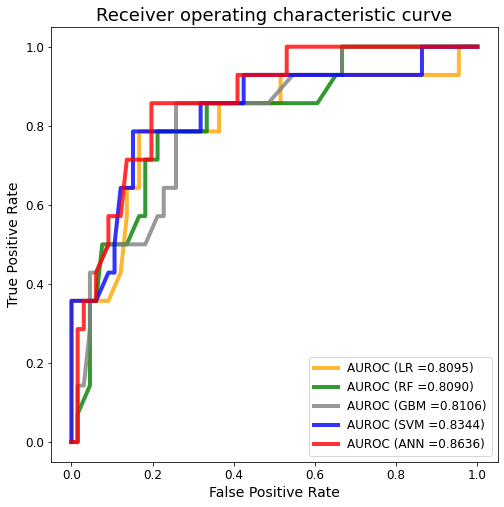

In [59]:
plt.plot(fpr_lr, tpr_lr, color='orange', label='AUROC (LR ={:.4f})'.format(auc_lr),lw=4, alpha=.8)
plt.plot(fpr_rf, tpr_rf, color='green', label='AUROC (RF ={:.4f})'.format(auc_rf),lw=4, alpha=.8)
plt.plot(fpr_gbm, tpr_gbm, color='gray', label='AUROC (GBM ={:.4f})'.format(auc_gbm),lw=4, alpha=.8)
plt.plot(fpr_svc, tpr_svc, color='blue', label='AUROC (SVM ={:.4f})'.format(auc_svc),lw=4, alpha=.8)
plt.plot(fpr_NL, tpr_NL, color='red', label='AUROC (ANN ={:.4f})'.format(auc_NL),lw=4, alpha=.8)

plt.rcParams['figure.figsize'] = [8, 8]
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.tif', dpi=300)
plt.show()

Combining PR curves of different machine learning methods

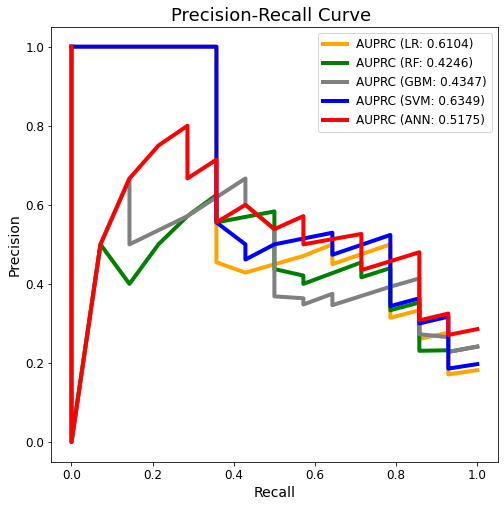

In [60]:
plt.plot(recall_lr, precision_lr, linewidth=4, color='orange',label='AUPRC (LR: {:.4f})'.format(auc_lr_pr))
plt.plot(recall_rf, precision_rf, linewidth=4, color='green',label='AUPRC (RF: {:.4f})'.format(auc_rf_pr))
plt.plot(recall_gbm, precision_gbm, linewidth=4,color='gray', label='AUPRC (GBM: {:.4f})'.format(auc_gbm_pr))
plt.plot(recall_svc, precision_svc, linewidth=4,color='blue', label='AUPRC (SVM: {:.4f})'.format(auc_svc_pr))
plt.plot(recall_NL, precision_NL, linewidth=4,color='red', label='AUPRC (ANN: {:.4f})'.format(auc_NL_pr))


#plt.plot([0, 1], [0.1, 0.1], 'k--')
plt.axis([-0.05, 1.05, -0.05, 1.05])
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(fontsize=12).get_frame().set_facecolor('white')
plt.legend(loc="upper right")
plt.title('{} '.format('Precision-Recall Curve'))
plt.savefig('PR_curve.tif', dpi=300)
plt.show()

# Deep learning model explaination by SHAP

In [61]:
import sklearn
import shap


# print the JS visualization code to the notebook
shap.initjs()

# train a NL classifier
model=tf.keras.models.load_model('./finalmodel/ANN_model.h5')

#class_weight
unique, counts=np.unique(train_Label, return_counts=True)
severe=counts[1]
mild=counts[0]
weight_for_0 = (1 / counts[0])*(counts.sum())/2.0 
weight_for_1 = (1 / counts[1])*(counts.sum())/2.0

class_weights = {0: weight_for_0, 1: weight_for_1}
      
model.fit(train_Features,train_Label, 
          class_weight=class_weights,
          epochs=400, batch_size=20, verbose=0)

In [62]:
test_probability=model.predict(test_Features)
pred_proba_NL = np.reshape(test_probability,test_probability.shape[0])
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model.predict, train_Features)
shap_values = explainer.shap_values(test_Features)

Using 718 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


HBox(children=(FloatProgress(value=0.0, max=80.0), HTML(value='')))

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [63]:
test_df2=test_df.reset_index(drop=True)
test_df2['NL_pred_proba']=pred_proba_NL

In [64]:
pd.set_option('display.max_columns', None)

In [65]:
test_df2.loc[(test_df2['Severity']==1)&(test_df2['NL_pred_proba']<0.5)]

,Severity,sex,age,NS1,IgM,IgG,NL_pred_proba
25,1,0,56,1,0,0,0.387269
45,1,0,63,1,0,0,0.269378


In [66]:
test_df2.loc[(test_df2['Severity']==0)&(test_df2['NL_pred_proba']>0.5)]

,Severity,sex,age,NS1,IgM,IgG,NL_pred_proba
0,0,0,72,1,0,0,0.637265
1,0,0,52,1,1,1,0.631098
7,0,0,83,1,0,1,0.746628
9,0,0,53,1,1,1,0.627189
12,0,0,83,1,0,0,0.812491
14,0,1,67,1,0,0,0.762108
18,0,1,77,1,0,1,0.591234
22,0,1,65,1,0,0,0.741187
24,0,1,75,1,0,0,0.799580
26,0,0,77,1,0,0,0.750380


In [67]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][25,:], test_df.iloc[25,1:6])

In [68]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][45,:], test_df.iloc[45,1:6])

In [69]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][59,:], test_df.iloc[59,1:6])

In [70]:
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model.predict, train_Features)
shap_values = explainer.shap_values(test_Features)

Using 718 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


HBox(children=(FloatProgress(value=0.0, max=80.0), HTML(value='')))

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


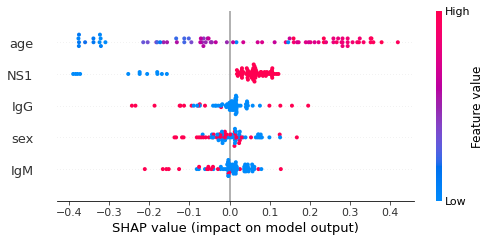

In [71]:
shap.summary_plot(shap_values[0], test_df.iloc[:,1:6], show=False)
plt.savefig('Summaryplot.tif', dpi=300)

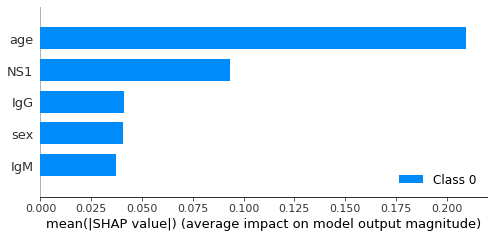

In [72]:
shap.summary_plot(shap_values, test_df.iloc[:,1:6], show=False)
plt.savefig('Summaryplot2.tif', dpi=300)

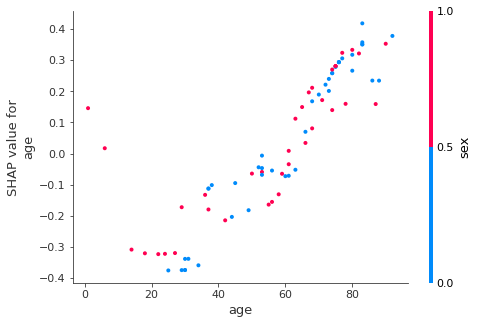

In [73]:
shap.dependence_plot("age", shap_values[0], test_df.iloc[:,1:6], show=False)
plt.savefig('Dependent_age.tif', dpi=300)

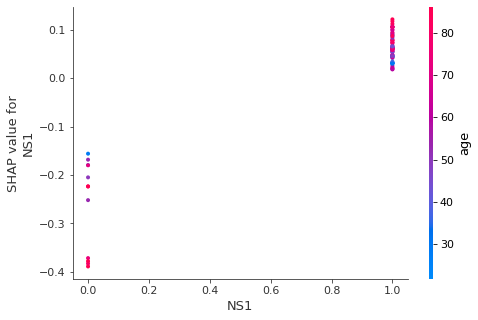

In [74]:
shap.dependence_plot("NS1", shap_values[0], test_df.iloc[:,1:6], show=False)
plt.savefig('Dependent_ns1.tif', dpi=300)

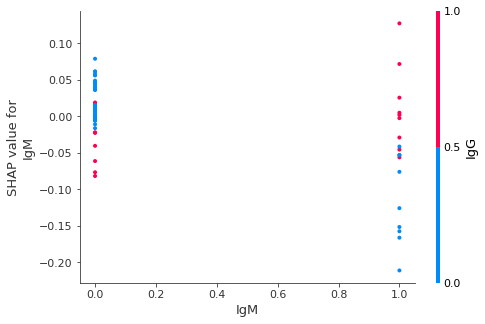

In [75]:
shap.dependence_plot("IgM", shap_values[0], test_df.iloc[:,1:6], show=False)
plt.savefig('Dependent_igm.tif', dpi=300)

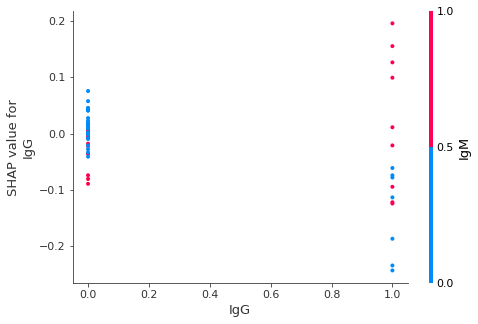

In [76]:
shap.dependence_plot("IgG", shap_values[0], test_df.iloc[:,1:6], show=False)
plt.savefig('Dependent_igg.tif', dpi=300)

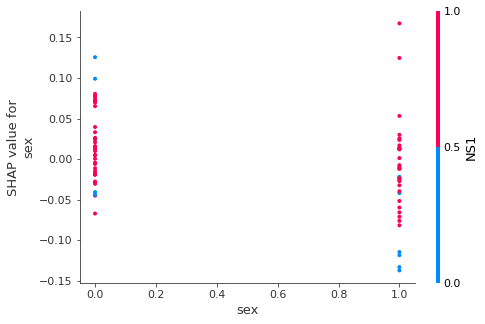

In [77]:
shap.dependence_plot("sex", shap_values[0], test_df.iloc[:,1:6], show=False)
plt.savefig('Dependent_sex.tif', dpi=300)

### Concat prediction_proba for each model to test set, save test set

In [78]:
def pred_proba(train_x, train_y, test_x, test_y):
    data=pd.DataFrame()
    data['severity']= test_y

    with open('./finalmodel/lr_clf_final_round.pkl', 'rb') as f:
        lr_clf = pickle.load(f)
    lr_clf.fit(train_x, train_y)
    pred_proba_lr = lr_clf.predict_proba(test_x)[:, 1]
    data['lr_pred_proba'] = pred_proba_lr


    with open('./finalmodel/rf_clf_final_round.pkl', 'rb') as f:
        rf_clf = pickle.load(f)
    rf_clf.fit(train_x, train_y)
    pred_proba_rf = rf_clf.predict_proba(test_x)[:, 1]
    data['rf_pred_proba'] = pred_proba_rf


    with open('./finalmodel/svc_clf_final_round.pkl', 'rb') as f:
        svc_clf = pickle.load(f)
    svc_clf.fit(train_x, train_y)
    pred_proba_svc = svc_clf.predict_proba(test_x)[:, 1]
    data['svc_pred_proba'] = pred_proba_svc

    with open('./finalmodel/gbm_clf_final_round.pkl', 'rb') as f:
        gbm_clf = pickle.load(f)
    gbm_clf.fit(train_x, train_y)
    pred_proba_gbm = gbm_clf.predict_proba(test_x)[:, 1]
    data['gbm_pred_proba'] = pred_proba_gbm

    model=tf.keras.models.load_model('./finalmodel/ANN_model.h5')
    unique, counts = np.unique(train_y, return_counts=True)
    weight_for_0 = (1 / counts[0])*(counts.sum())/2.0 
    weight_for_1 = (1 / counts[1])*(counts.sum())/2.0
    class_weights = {0: weight_for_0, 1: weight_for_1}
    model.fit(train_x,train_y, 
          class_weight=class_weights,
          epochs=400, batch_size=20, verbose=2)

    test_probability=model.predict(test_x)
    pred_proba_NL = np.reshape(test_probability,test_probability.shape[0])
    data['NL_pred_proba'] = pred_proba_NL

    return data

In [79]:
data_test=pred_proba(train_Features, train_Label, test_Features, test_Label)

Train on 718 samples
Epoch 1/400
718/718 - 1s - loss: 0.4311 - auc_2564: 0.8689
Epoch 2/400
718/718 - 0s - loss: 0.4366 - auc_2564: 0.8664
Epoch 3/400
718/718 - 0s - loss: 0.4323 - auc_2564: 0.8687
Epoch 4/400
718/718 - 0s - loss: 0.4319 - auc_2564: 0.8672
Epoch 5/400
718/718 - 0s - loss: 0.4258 - auc_2564: 0.8716
Epoch 6/400
718/718 - 0s - loss: 0.4343 - auc_2564: 0.8680
Epoch 7/400
718/718 - 0s - loss: 0.4319 - auc_2564: 0.8729
Epoch 8/400
718/718 - 0s - loss: 0.4362 - auc_2564: 0.8684
Epoch 9/400
718/718 - 0s - loss: 0.4325 - auc_2564: 0.8689
Epoch 10/400
718/718 - 0s - loss: 0.4271 - auc_2564: 0.8734
Epoch 11/400
718/718 - 0s - loss: 0.4225 - auc_2564: 0.8732
Epoch 12/400
718/718 - 0s - loss: 0.4442 - auc_2564: 0.8672
Epoch 13/400
718/718 - 0s - loss: 0.4510 - auc_2564: 0.8605
Epoch 14/400
718/718 - 0s - loss: 0.4346 - auc_2564: 0.8706
Epoch 15/400
718/718 - 0s - loss: 0.4333 - auc_2564: 0.8678
Epoch 16/400
718/718 - 0s - loss: 0.4334 - auc_2564: 0.8697
Epoch 17/400
718/718 - 0s - 

Epoch 137/400
718/718 - 0s - loss: 0.4570 - auc_2564: 0.8515
Epoch 138/400
718/718 - 0s - loss: 0.4336 - auc_2564: 0.8698
Epoch 139/400
718/718 - 0s - loss: 0.4387 - auc_2564: 0.8632
Epoch 140/400
718/718 - 0s - loss: 0.4260 - auc_2564: 0.8709
Epoch 141/400
718/718 - 0s - loss: 0.4347 - auc_2564: 0.8681
Epoch 142/400
718/718 - 0s - loss: 0.4225 - auc_2564: 0.8798
Epoch 143/400
718/718 - 0s - loss: 0.4195 - auc_2564: 0.8767
Epoch 144/400
718/718 - 0s - loss: 0.4382 - auc_2564: 0.8681
Epoch 145/400
718/718 - 0s - loss: 0.4335 - auc_2564: 0.8679
Epoch 146/400
718/718 - 0s - loss: 0.4245 - auc_2564: 0.8752
Epoch 147/400
718/718 - 0s - loss: 0.4336 - auc_2564: 0.8709
Epoch 148/400
718/718 - 0s - loss: 0.4374 - auc_2564: 0.8648
Epoch 149/400
718/718 - 0s - loss: 0.4215 - auc_2564: 0.8793
Epoch 150/400
718/718 - 0s - loss: 0.4161 - auc_2564: 0.8793
Epoch 151/400
718/718 - 0s - loss: 0.4295 - auc_2564: 0.8717
Epoch 152/400
718/718 - 0s - loss: 0.4260 - auc_2564: 0.8703
Epoch 153/400
718/718 - 

Epoch 272/400
718/718 - 0s - loss: 0.4406 - auc_2564: 0.8659
Epoch 273/400
718/718 - 0s - loss: 0.4531 - auc_2564: 0.8600
Epoch 274/400
718/718 - 0s - loss: 0.4303 - auc_2564: 0.8704
Epoch 275/400
718/718 - 0s - loss: 0.4228 - auc_2564: 0.8761
Epoch 276/400
718/718 - 0s - loss: 0.4420 - auc_2564: 0.8643
Epoch 277/400
718/718 - 0s - loss: 0.4521 - auc_2564: 0.8567
Epoch 278/400
718/718 - 0s - loss: 0.4308 - auc_2564: 0.8732
Epoch 279/400
718/718 - 0s - loss: 0.4288 - auc_2564: 0.8704
Epoch 280/400
718/718 - 0s - loss: 0.4292 - auc_2564: 0.8701
Epoch 281/400
718/718 - 0s - loss: 0.4460 - auc_2564: 0.8672
Epoch 282/400
718/718 - 0s - loss: 0.4385 - auc_2564: 0.8640
Epoch 283/400
718/718 - 0s - loss: 0.4302 - auc_2564: 0.8710
Epoch 284/400
718/718 - 0s - loss: 0.4122 - auc_2564: 0.8825
Epoch 285/400
718/718 - 0s - loss: 0.4185 - auc_2564: 0.8800
Epoch 286/400
718/718 - 0s - loss: 0.4309 - auc_2564: 0.8709
Epoch 287/400
718/718 - 0s - loss: 0.4275 - auc_2564: 0.8728
Epoch 288/400
718/718 - 

In [80]:
data_test

,severity,lr_pred_proba,rf_pred_proba,svc_pred_proba,gbm_pred_proba,NL_pred_proba
0,0,0.295814,0.317929,0.281243,0.287239,0.617906
1,0,0.169919,0.128944,0.087616,0.021902,0.686745
2,0,0.033886,0.014008,0.050424,0.002427,0.001093
3,1,0.347321,0.445143,0.343668,0.511871,0.745825
4,0,0.078457,0.120880,0.080967,0.131271,0.480244
...,...,...,...,...,...,...
75,0,0.018815,0.031751,0.031789,0.005063,0.000000
76,0,0.300571,0.285506,0.197873,0.320490,0.520860
77,0,0.031870,0.024220,0.050642,0.021015,0.146838
78,0,0.057562,0.028806,0.029761,0.001948,0.000000


## Class breakdown per model

In [81]:
def plot_class_breakdown_hist(df, var, var_name, plot_title, xlog=False, ylog=False, **histkwargs):
    df[var][df.severity == 1].hist(alpha=.5, label='Severe', color = "green", **histkwargs)
    df[var][df.severity == 0].hist(alpha=.5, label='Mild', color = "red", **histkwargs)
    plt.xlabel(var_name)
    plt.title(plot_title)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.xlim(xmax=1, xmin=0)   
    plt.ylim(ymax=20, ymin=0)
    plt.legend()
    plt.savefig(var_name + ' Class Breakdown.png');

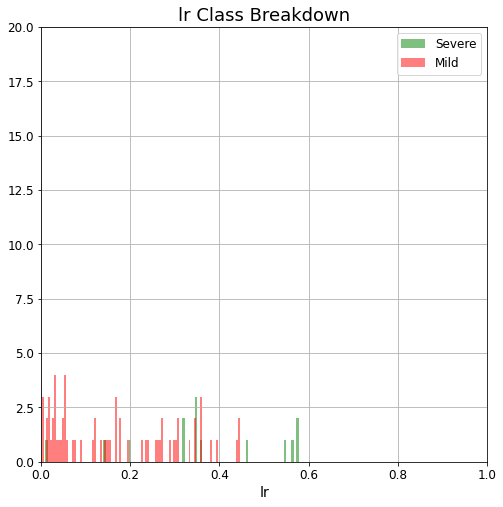

In [82]:
plot_class_breakdown_hist(data_test, 'lr_pred_proba', var_name='lr', 
                          plot_title='lr Class Breakdown', bins=100)

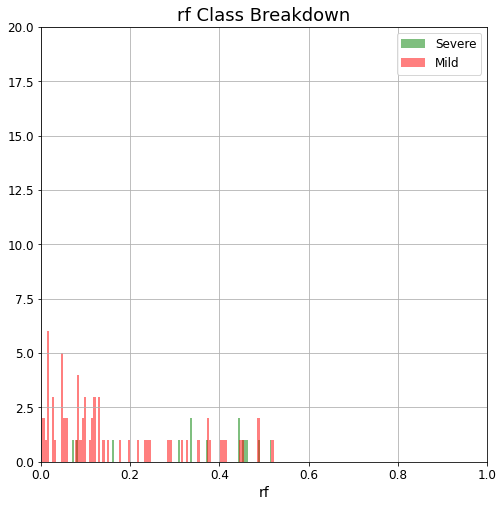

In [83]:
plot_class_breakdown_hist(data_test, 'rf_pred_proba', var_name='rf', 
                          plot_title='rf Class Breakdown', bins=100)

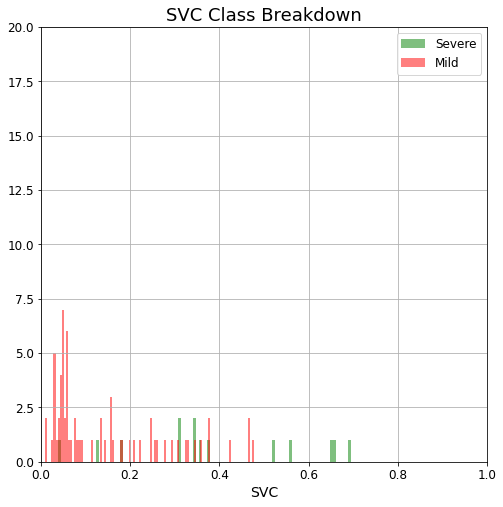

In [84]:
plot_class_breakdown_hist(data_test, 'svc_pred_proba', var_name='SVC', 
                          plot_title='SVC Class Breakdown', bins=100)

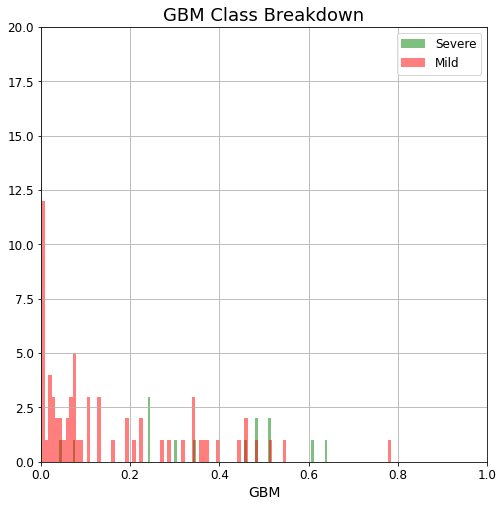

In [85]:
plot_class_breakdown_hist(data_test, 'gbm_pred_proba', var_name='GBM', 
                          plot_title='GBM Class Breakdown', bins=100)

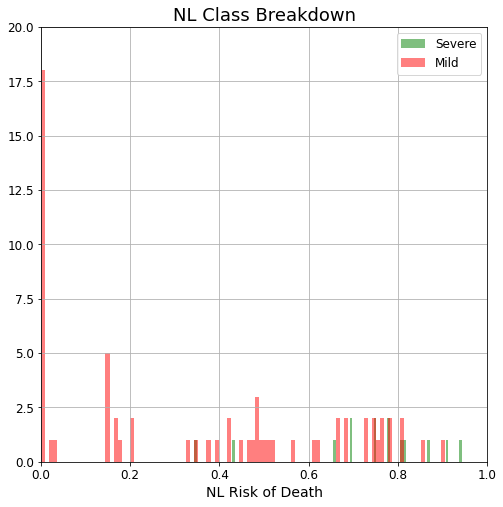

In [86]:
plot_class_breakdown_hist(data_test, 'NL_pred_proba', var_name='NL Risk of Death', 
                          plot_title='NL Class Breakdown', bins=100)

# 10-fold cross validation test

In [87]:
tprs_ANN = []

tprs_lr = []

tprs_rf = []

tprs_gbm = []

tprs_svc = []

mean_fpr_ANN = np.linspace(0, 1, 100)
mean_fpr_lr = np.linspace(0, 1, 100)
mean_fpr_rf = np.linspace(0, 1, 100)
mean_fpr_gbm = np.linspace(0, 1, 100)
mean_fpr_svc = np.linspace(0, 1, 100)

# Logistic regression 10-fold cross validation test

In [88]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_lr=[]
roc_auc_lr=[]
f1_lr=[]
auc_lr_pr_all=[]
ap_lr_pr_all=[]
for train, test in kfold.split(X, Y):
    # Import model and retrain
    with open('./finalmodel/lr_clf_final_round.pkl', 'rb') as f:
        lr_clf = pickle.load(f)
    lr_clf.fit(X[train], Y[train])

    
    accu_lr = balanced_accuracy_score(Y[test], lr_clf.predict(X[test]))
   # create model
    pred_proba_lr = lr_clf.predict_proba(X[test])
    pred_proba_lr = pred_proba_lr[:, 1]
    yhat = lr_clf.predict(X[test])
    
    fpr_lr, tpr_lr, thresholds_lr = roc_curve(Y[test],  pred_proba_lr)
    tprs_lr.append(interp(mean_fpr_lr, fpr_lr, tpr_lr))
    tprs_lr[-1][0] = 0.0
    
    auc_lr = roc_auc_score(Y[test],  pred_proba_lr)
    
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_lr)
    # calculate F1 score
    f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
    auc_lr_pr=auc(recall, precision)
    # calculate average precision score
    ap_lr_pr= average_precision_score(Y[test], pred_proba_lr)
    scores_lr.append( accu_lr )
    roc_auc_lr.append( auc_lr )
    f1_lr.append( f1)
    auc_lr_pr_all.append(auc_lr_pr)
    ap_lr_pr_all.append(ap_lr_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_lr)*100, numpy.std(scores_lr)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_lr)*100, numpy.std(roc_auc_lr)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_lr)*100, numpy.std(f1_lr)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_lr_pr_all)*100, numpy.std(auc_lr_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_lr_pr_all)*100, numpy.std(ap_lr_pr_all)*100))

scores=54.25% (+/- 4.68%)
roc_auc=81.35% (+/- 7.18%)
f1=16.06% (+/- 14.08%)
auc=49.02% (+/- 14.28%)
ap=51.66% (+/- 13.36%)


# Random forest 10-fold cross validation test

In [89]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_rf=[]
roc_auc_rf=[]
f1_rf=[]
auc_rf_pr_all=[]
ap_rf_pr_all=[]
for train, test in kfold.split(X, Y):
  # create model
   with open('./finalmodel/rf_clf_final_round.pkl', 'rb') as f:
        rf_clf = pickle.load(f)
        rf_clf.fit(X[train], Y[train])
    
        accu_rf = balanced_accuracy_score(Y[test], rf_clf.predict(X[test]))
   # create model
        pred_proba_rf = rf_clf.predict_proba(X[test])
        pred_proba_rf = pred_proba_rf[:, 1]
        yhat = rf_clf.predict(X[test])
        auc_rf = roc_auc_score(Y[test],  pred_proba_rf)
        
        fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y[test],  pred_proba_rf)
        tprs_rf.append(interp(mean_fpr_rf, fpr_rf, tpr_rf))
        tprs_rf[-1][0] = 0.0
        
    # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_rf)
    # calculate F1 score
        f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
        auc_rf_pr=auc(recall, precision)
    # calculate average precision score
        ap_rf_pr= average_precision_score(Y[test], pred_proba_rf)
        scores_rf.append( accu_rf )
        roc_auc_rf.append(auc_rf)
        f1_rf.append( f1)
        auc_rf_pr_all.append(auc_rf_pr)
        ap_rf_pr_all.append(ap_rf_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_rf)*100, numpy.std(scores_rf)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_rf)*100, numpy.std(roc_auc_rf)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_rf)*100, numpy.std(f1_rf)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_rf_pr_all)*100, numpy.std(auc_rf_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_rf_pr_all)*100, numpy.std(ap_rf_pr_all)*100))

scores=54.48% (+/- 5.43%)
roc_auc=81.71% (+/- 5.43%)
f1=16.49% (+/- 14.82%)
auc=47.31% (+/- 8.75%)
ap=49.25% (+/- 8.68%)


# Gradient boosting machine 10-fold cross validation test

In [90]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_gbm=[]
roc_auc_gbm=[]
f1_gbm=[]
auc_gbm_pr_all=[]
ap_gbm_pr_all=[]
for train, test in kfold.split(X, Y):
  # create model
   with open('./finalmodel/gbm_clf_final_round.pkl', 'rb') as f:
        gbm_clf = pickle.load(f)
        gbm_clf.fit(X[train], Y[train])
    
        accu_gbm = balanced_accuracy_score(Y[test], gbm_clf.predict(X[test]))
   # create model
        pred_proba_gbm = gbm_clf.predict_proba(X[test])
        pred_proba_gbm = pred_proba_gbm[:, 1]
        yhat = gbm_clf.predict(X[test])
        
        auc_gbm = roc_auc_score(Y[test],  pred_proba_gbm)
        
        fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(Y[test],  pred_proba_gbm)
        tprs_gbm.append(interp(mean_fpr_gbm, fpr_gbm, tpr_gbm))
        tprs_gbm[-1][0] = 0.0
    # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_gbm)
    # calculate F1 score
        f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
        auc_gbm_pr=auc(recall, precision)
    # calculate average precision score
        ap_gbm_pr= average_precision_score(Y[test], pred_proba_gbm)
        scores_gbm.append( accu_gbm )
        roc_auc_gbm.append(auc_gbm)
        f1_gbm.append( f1)
        auc_gbm_pr_all.append(auc_gbm_pr)
        ap_gbm_pr_all.append(ap_gbm_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_rf)*100, numpy.std(scores_rf)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_gbm)*100, numpy.std(roc_auc_gbm)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_rf)*100, numpy.std(f1_rf)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_rf_pr_all)*100, numpy.std(auc_rf_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_rf_pr_all)*100, numpy.std(ap_rf_pr_all)*100))

scores=54.48% (+/- 5.43%)
roc_auc=80.90% (+/- 5.94%)
f1=16.49% (+/- 14.82%)
auc=47.31% (+/- 8.75%)
ap=49.25% (+/- 8.68%)


# SVC 10-fold cross validation test

In [91]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_svc=[]
roc_auc_svc=[]
f1_svc=[]
auc_svc_pr_all=[]
ap_svc_pr_all=[]
for train, test in kfold.split(X, Y):
  # create model
   with open('./finalmodel/svc_clf_final_round.pkl', 'rb') as f:
        svc_clf = pickle.load(f)
        svc_clf.fit(X[train], Y[train])
    
        accu_svc = balanced_accuracy_score(Y[test], svc_clf.predict(X[test]))
   # create model
        pred_proba_svc = svc_clf.predict_proba(X[test])
        pred_proba_svc = pred_proba_svc[:, 1]
        yhat = svc_clf.predict(X[test])
        
        auc_svc = roc_auc_score(Y[test],  pred_proba_svc)
        
        fpr_svc, tpr_svc, thresholds_svc = roc_curve(Y[test],  pred_proba_svc)
        tprs_svc.append(interp(mean_fpr_svc, fpr_svc, tpr_svc))
        tprs_svc[-1][0] = 0.0
        
    # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_svc)
    # calculate F1 score
        f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
        auc_svc_pr=auc(recall, precision)
    # calculate average precision score
        ap_svc_pr= average_precision_score(Y[test], pred_proba_svc)
        scores_svc.append( accu_svc )
        roc_auc_svc.append(auc_svc)
        f1_svc.append( f1)
        auc_svc_pr_all.append(auc_svc_pr)
        ap_svc_pr_all.append(ap_svc_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_svc)*100, numpy.std(scores_svc)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_svc)*100, numpy.std(roc_auc_svc)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_svc)*100, numpy.std(f1_svc)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_svc_pr_all)*100, numpy.std(auc_svc_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_svc_pr_all)*100, numpy.std(ap_svc_pr_all)*100))

scores=74.85% (+/- 6.88%)
roc_auc=82.17% (+/- 6.24%)
f1=50.19% (+/- 7.49%)
auc=51.54% (+/- 14.16%)
ap=53.82% (+/- 13.27%)


# Deep learning 10-fold cross validation test

In [92]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_ANN=[]
roc_auc_ANN=[]
auc_ANN_pr_all=[]
ap_ANN_pr_all=[]
for train, test in kfold.split(X, Y):
   # create model
    model=tf.keras.models.load_model('./finalmodel/ANN_model.h5')
    unique, counts=numpy.unique(Y[train], return_counts=True)
    severe=counts[1]
    mild=counts[0]
    weight_for_0 = (1 / counts[0])*(counts.sum())/2.0 
    weight_for_1 = (1 / counts[1])*(counts.sum())/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    
    # Fit the model
    model.fit(X[train],Y[train], 
          epochs=400, batch_size=20, class_weight=class_weight, verbose=0)
    
    
    
    test_probability=model.predict(X[test])
    pred_proba_ANN = np.reshape(test_probability,test_probability.shape[0])
    
    yhat = model.predict_classes(X[test])
    
    fpr_ANN, tpr_ANN, thresholds_ANN = roc_curve(Y[test], pred_proba_ANN)
    tprs_ANN.append(interp(mean_fpr_ANN, fpr_ANN, tpr_ANN))
    tprs_ANN[-1][0] = 0.0
    
    accu_ANN = balanced_accuracy_score(Y[test], model.predict_classes(X[test]))
    auc_ANN = roc_auc_score(Y[test],  pred_proba_ANN)
    
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_ANN)
    # calculate precision-recall AUC
    auc_ANN_pr=auc(recall, precision)
    # calculate average precision score
    ap_ANN_pr= average_precision_score(Y[test], pred_proba_ANN)
    scores_ANN.append(accu_ANN)
    roc_auc_ANN.append(auc_ANN)
    auc_ANN_pr_all.append(auc_ANN_pr)
    ap_ANN_pr_all.append(ap_ANN_pr)

print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_ANN)*100, numpy.std(scores_ANN)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_ANN)*100, numpy.std(roc_auc_ANN)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_ANN_pr_all)*100, numpy.std(auc_ANN_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_ANN_pr_all)*100, numpy.std(ap_ANN_pr_all)*100))

scores=75.23% (+/- 2.75%)
roc_auc=83.14% (+/- 2.68%)
auc=52.99% (+/- 10.15%)
ap=55.41% (+/- 9.26%)


# Mean receiver operating characteristic curve

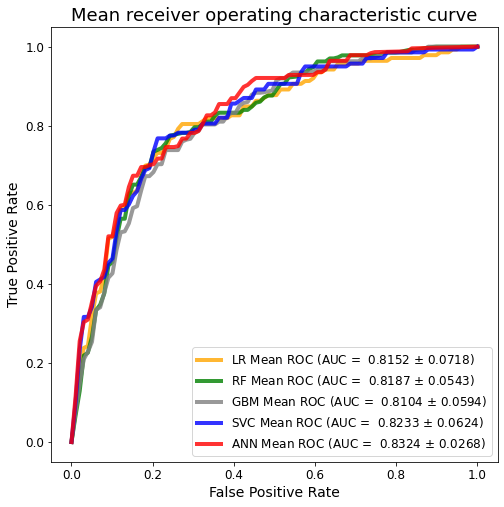

0.7523476523476524
0.5424908424908426
0.5448135198135198
0.5866550116550118
0.7484598734598734
0.5540534402180637
0.5165508287935204
0.4924628864805542
0.47687097741788725
0.5382420087452305


In [93]:

#LR curve
mean_tpr_lr = np.mean(tprs_lr, axis=0)
mean_tpr_lr[-1] = 1.0
mean_auc_lr = sklearn.metrics.auc(mean_fpr_lr, mean_tpr_lr)
std_auc_lr = np.std(roc_auc_lr)
plt.plot(mean_fpr_lr, mean_tpr_lr, color='orange',label='% s Mean ROC (AUC =  %0.4f $\pm$ %0.4f)'% ('LR', mean_auc_lr, std_auc_lr),  lw=4, alpha=.8)

#RF curve
mean_tpr_rf = np.mean(tprs_rf, axis=0)
mean_tpr_rf[-1] = 1.0
mean_auc_rf = sklearn.metrics.auc(mean_fpr_rf, mean_tpr_rf)
std_auc_rf = np.std(roc_auc_rf)
plt.plot(mean_fpr_rf, mean_tpr_rf, color='green',label='% s Mean ROC (AUC =  %0.4f $\pm$ %0.4f)'% ('RF', mean_auc_rf, std_auc_rf),  lw=4, alpha=.8)

#GBM curve
mean_tpr_gbm = np.mean(tprs_gbm, axis=0)
mean_tpr_gbm[-1] = 1.0
mean_auc_gbm = sklearn.metrics.auc(mean_fpr_gbm, mean_tpr_gbm)
std_auc_gbm = np.std(roc_auc_gbm)
plt.plot(mean_fpr_gbm, mean_tpr_gbm, color='gray',label='% s Mean ROC (AUC =  %0.4f $\pm$ %0.4f)'% ('GBM', mean_auc_gbm, std_auc_gbm),  lw=4, alpha=.8)

#SVC curve
mean_tpr_svc = np.mean(tprs_svc, axis=0)
mean_tpr_svc[-1] = 1.0
mean_auc_svc = sklearn.metrics.auc(mean_fpr_svc, mean_tpr_svc)
std_auc_svc = np.std(roc_auc_svc)
plt.plot(mean_fpr_svc, mean_tpr_svc, color='blue',label='% s Mean ROC (AUC =  %0.4f $\pm$ %0.4f)'% ('SVC', mean_auc_svc, std_auc_svc),  lw=4, alpha=.8)

# ANN curve
mean_tpr_ANN = np.mean(tprs_ANN, axis=0)
mean_tpr_ANN[-1] = 1.0
mean_auc_ANN = sklearn.metrics.auc(mean_fpr_ANN, mean_tpr_ANN)
std_auc_ANN = np.std(roc_auc_ANN)
plt.plot(mean_fpr_ANN, mean_tpr_ANN, color='red',label='% s Mean ROC (AUC =  %0.4f $\pm$ %0.4f)'% ('ANN', mean_auc_ANN, std_auc_ANN),  lw=4, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.savefig('models_roc_curve_10folds_20200528.tif', dpi=300)
plt.show()
  
print(np.mean(scores_ANN))
print(np.mean(scores_lr))
print(np.mean(scores_rf))
print(np.mean(scores_gbm))
print(np.mean(scores_svc))

print(np.mean(ap_ANN_pr_all))
print(np.mean(ap_lr_pr_all))
print(np.mean(ap_rf_pr_all))
print(np.mean(ap_gbm_pr_all))
print(np.mean(ap_svc_pr_all))

In [94]:
Finaldf=pd.DataFrame([[numpy.mean(scores_lr), numpy.mean(scores_svc), numpy.mean(scores_rf), numpy.mean(scores_gbm), numpy.mean(scores_ANN)],
              [numpy.std(scores_lr), numpy.std(scores_svc), numpy.std(scores_rf), numpy.std(scores_gbm), numpy.std(scores_ANN)],
              [mean_auc_lr, mean_auc_svc, mean_auc_rf,mean_auc_gbm, mean_auc_ANN],
              [std_auc_lr, std_auc_svc, std_auc_rf,std_auc_gbm, std_auc_ANN],
              [numpy.mean(auc_lr_pr_all), numpy.mean(auc_svc_pr_all), numpy.mean(auc_rf_pr_all), numpy.mean(auc_gbm_pr_all),  numpy.mean(auc_ANN_pr_all)],
              [numpy.std(auc_lr_pr_all), numpy.std(auc_svc_pr_all), numpy.std(auc_rf_pr_all), numpy.std(auc_gbm_pr_all),  numpy.std(auc_ANN_pr_all)],
              [numpy.mean(ap_lr_pr_all), numpy.mean(ap_svc_pr_all), numpy.mean(ap_rf_pr_all), numpy.mean(ap_gbm_pr_all),  numpy.mean(ap_ANN_pr_all)],
              [numpy.std(ap_lr_pr_all), numpy.std(ap_svc_pr_all), numpy.std(ap_rf_pr_all), numpy.std(ap_gbm_pr_all),  numpy.std(ap_ANN_pr_all)]],
              index=['Balance accuracy','Balance accuracy SD','Area Under (ROC) Curve', 'Area Under (ROC) Curve SD','Area Under (Precision-recall) Curve', 'Area Under (Precision-recall) Curve SD','Average precision score', 'Average precision score SD' ],
              columns=['Logistic Regression', 'Support vector machine', 'Random forests', 'Gradient boosting machine',  'Deep Learner'])

# 10-fold cross validation test final results

In [95]:
Finaldf

,Logistic Regression,Support vector machine,Random forests,Gradient boosting machine,Deep Learner
Balance accuracy,0.542491,0.748460,0.544814,0.586655,0.752348
Balance accuracy SD,0.046787,0.068788,0.054341,0.071228,0.027546
Area Under (ROC) Curve,0.815188,0.823313,0.818689,0.810386,0.832427
Area Under (ROC) Curve SD,0.071751,0.062367,0.054338,0.059432,0.026849
Area Under (Precision-recall) Curve,0.490238,0.515403,0.473100,0.456123,0.529944
Area Under (Precision-recall) Curve SD,0.142758,0.141575,0.087479,0.151518,0.101499
Average precision score,0.516551,0.538242,0.492463,0.476871,0.554053
Average precision score SD,0.133576,0.132703,0.086821,0.143811,0.092645


In [96]:
Finaldf.to_csv('Finaltable.csv')